# Actionable clustering

Clustering is a way to group together cells that are more similar to each other than the rest; but how do we get from these groups to cell types (especially as we defined them in the evolutionary context?)

## AASCD Master Plan For Finding Cell Types From Clusters

1. We want to have clusters that correspond to cell types.
2. Our evolutionary theory of cell types predicts that there should be a number of genes (probably dozens of them) that is specifically expressed in the cell type (along with a CoRC).
3. Our proxy for finding specifically expressed genes is to look for differential expression. BUT: it is important to compare pairs of clusters to each other rather than each cluster to the background (example: one gene is DE in two clusters; comparing against the background this is lost).
4. it is easier to find the true cell types if we overcluster and merge rather than underclustering, as it is not clear how we should split. We noticed that in fused clusters the true expression patterns will get blurred.

Algorithm:

- overcluster!
- calculate pairwise similarity between all clusters
- look at two most similar clusters A, B:
    - look at DGE between A and B.
    - we need at least X genes to be specific for A and X genes to be specific for B.
    - if true, go to next most similar pair.
    - otherwise, A, B get merged; go to previous step.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

In [3]:
annot = pd.read_csv("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_annot.csv")
annot.set_index("index", inplace=True)
adata.obs = adata.obs.join(annot)

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
sc.pp.neighbors(adata, use_rep="X", key_added="only_genes")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'only_genes'
    obsp: 'only_genes_distances', 'only_genes_connectivities'

In [8]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, use_rep="X_pca", n_pcs=10, key_added="pca")

In [9]:
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'only_genes', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'only_genes_distances', 'only_genes_connectivities', 'pca_distances', 'pca_connectivities'

In [10]:
sc.tl.leiden(adata, neighbors_key="only_genes", key_added="only_genes")

In [11]:
sc.tl.leiden(adata, neighbors_key="pca", key_added="pca")

In [12]:
sc.tl.umap(adata, neighbors_key="pca")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


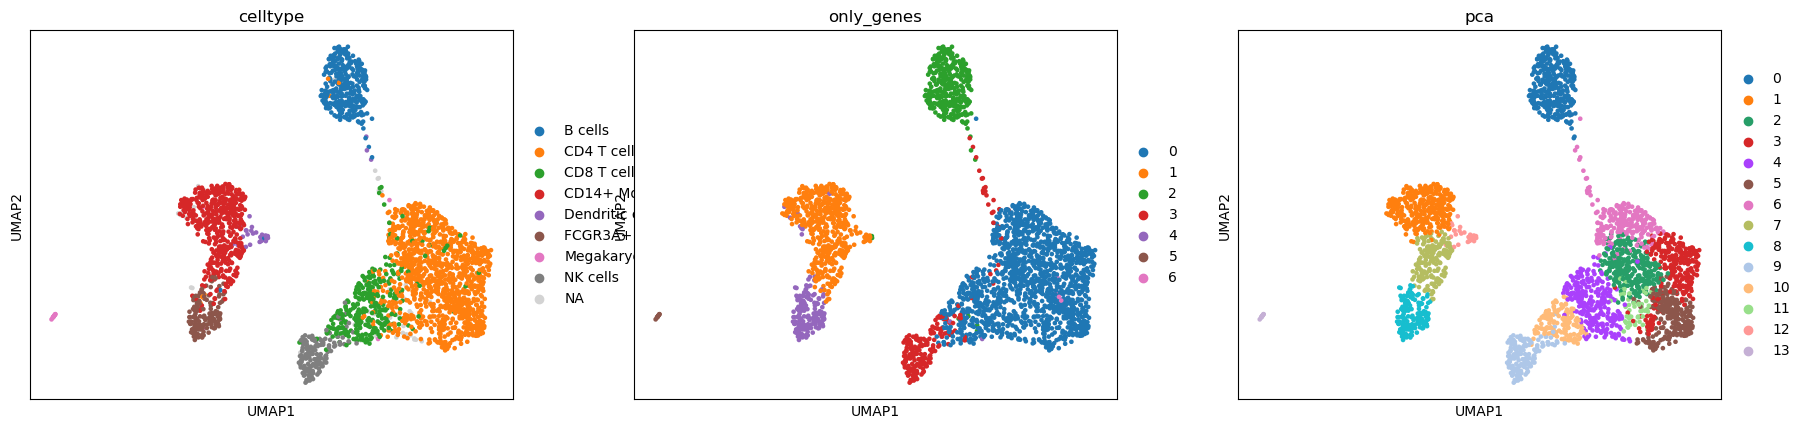

In [13]:
sc.pl.umap(adata, color=["celltype", "only_genes", "pca"])

In [14]:
import cluster

In [15]:
adata.raw = adata

In [16]:
cluster.merge_clusters(adata, "pca", num_genes=85)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


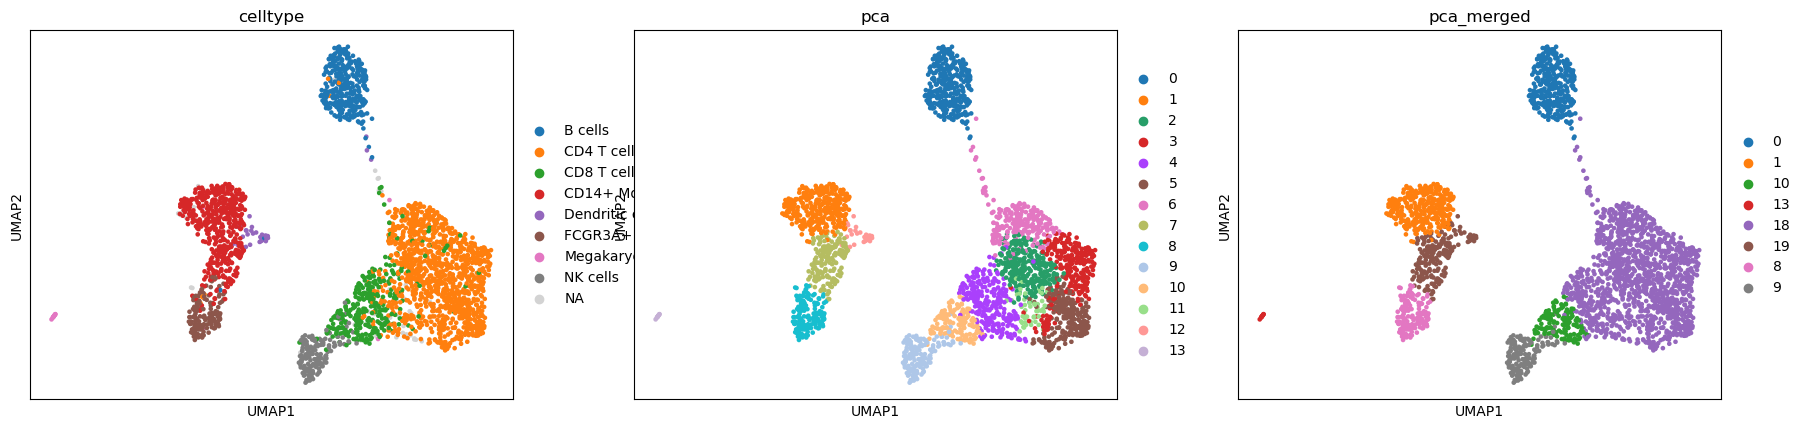

In [17]:
sc.pl.umap(adata, color=["celltype", "pca", "pca_merged"])

In [18]:
sc.tl.paga(adata, groups="pca_merged", neighbors_key="pca")

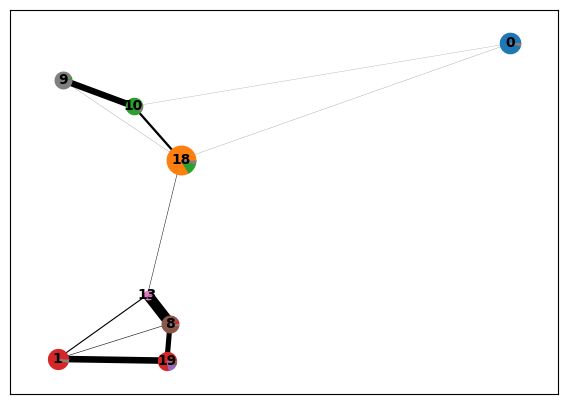

In [19]:
sc.pl.paga(adata, color="celltype")

In [30]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)

ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [31]:
%%R
library(stats)
library(ape)

In [32]:
log_norm = cluster.grouped_obs_mean(adata, "celltype")

In [67]:
%%R -i log_norm
distance_matrix <- dist(t(log_norm), method = "euclidean")
nj.tree <- nj(distance_matrix)

nj.boot.tree <- boot.phylo(nj.tree, t(log_norm), FUN = function(x) nj(dist(x)), B = 1000)

Running bootstraps:       100 / 1000 200 / 1000 300 / 1000 400 / 1000 500 / 1000 600 / 1000 700 / 1000 800 / 1000 900 / 1000 1000 / 1000
Calculating bootstrap values... done.


In [68]:
%%R
nj.tree$node.label <- round(nj.boot.tree / 10)

nj.tree$edge.length <- sqrt(nj.tree$edge.length)

node_col <- nj.tree$node.label
node_col[nj.tree$node.label >= 80] <- "black"
node_col[nj.tree$node.label < 80] <- "yellow"
node_col[nj.tree$node.label < 50] <- "red"

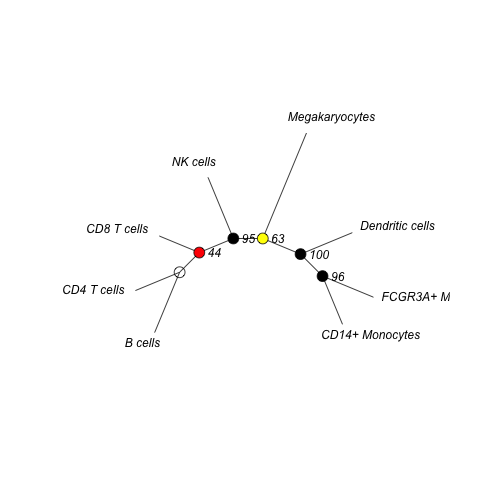

In [69]:
%%R
plot.phylo(nj.tree, type = "unrooted", show.node.label = TRUE, label.offset=0.3)
for (i in 1:length(node_col)) {
    nodelabels(node = length(nj.tree$tip.label)+i, pch=21, col="black", bg=node_col[i], cex=2)
}

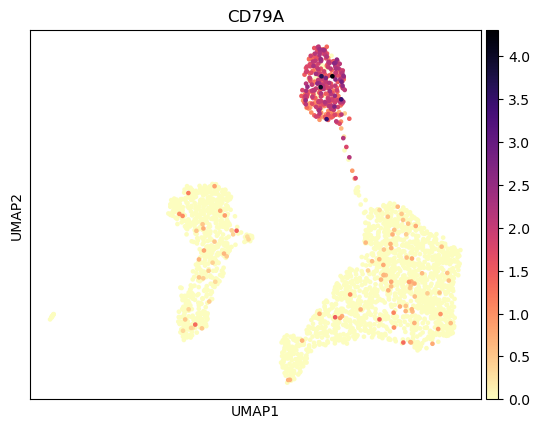

In [72]:
sc.pl.umap(adata, color="CD79A", cmap="magma_r")

In [73]:
sc.tl.rank_genes_groups(adata, groupby="celltype", method="wilcoxon")

In [81]:
genes = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])["B cells"][:50]

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


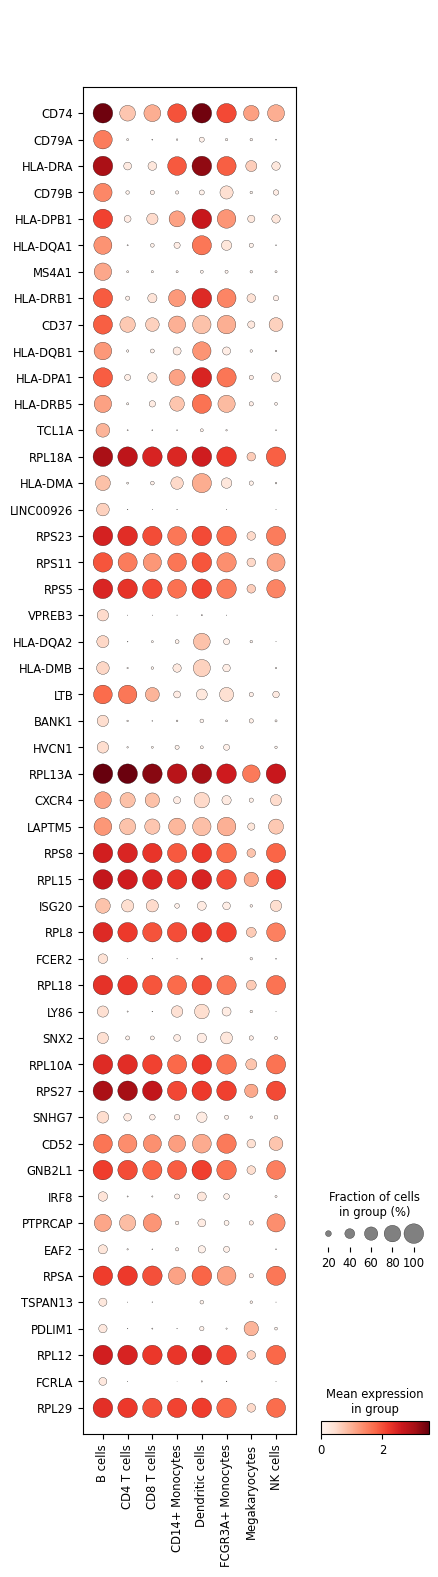

In [84]:
sc.pl.dotplot(adata, genes, groupby="celltype", swap_axes=True)

- CD74: part of the B cell surface marker complex

